In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
import os
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [2]:
fileName = 'C:/Users/akaba/Downloads/usa_00009.csv'
file = pd.read_csv(fileName)
dfCDI = pd.DataFrame(file)

C:\Users\akaba\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
dfCDI.shape

(6086626, 38)

In [4]:
dfCDI = dfCDI[dfCDI['AGE']>=21]
dfCDI.shape

(4199977, 38)

In [5]:
dfHomeOwn=dfCDI[dfCDI['OWNERSHP']==1]
dfHomeOwn.RENTGRS.describe()

count    2580898.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: RENTGRS, dtype: float64

In [6]:
dfCDI = dfCDI[dfCDI['OWNERSHP']!=0]
dfCDI.shape

(4093964, 38)

In [7]:
dfCDI['affrentdec'] = dfCDI['RENTGRS']*12/dfCDI['HHINCOME']

In [8]:
def housingFunc(own, affrentdec):
    if own==1:
        housingCat=2
    elif own==2 and affrentdec<.3:
        housingCat=1
    else:
        housingCat=0
    return housingCat

In [9]:
dfCDI['HousingCat'] = dfCDI.apply(lambda x: housingFunc(x['OWNERSHP'], x['affrentdec']), axis=1)
dfCDI['HousingCat'].value_counts()

2    2580898
1     896373
0     616693
Name: HousingCat, dtype: int64

In [10]:
dfCDI['EDUCbin'] = [1 if x >=8 else 0 for x in dfCDI['EDUC']]
dfCDI['EDUCbin'].value_counts()

0    2687862
1    1406102
Name: EDUCbin, dtype: int64

In [11]:
dfCDI['TRANTIME'].value_counts()

0      1938226
15      328333
30      311230
20      310880
10      273784
        ...   
117          2
114          2
126          1
119          1
118          1
Name: TRANTIME, Length: 132, dtype: int64

## Split by year

In [12]:
dfCDI['YEAR'].value_counts()

2010    1219545
2000    1119919
1990     980231
1980     774269
Name: YEAR, dtype: int64

In [13]:
df10=dfCDI[dfCDI['YEAR']==2010]
df00=dfCDI[dfCDI['YEAR']==2000]
df90=dfCDI[dfCDI['YEAR']==1990]
df80=dfCDI[dfCDI['YEAR']==1980]

In [14]:
print(dfCDI.columns.get_loc("HousingCat"))
print(dfCDI.columns.get_loc("EDUCbin"))
print(dfCDI.columns.get_loc("TRANTIME"))
print(dfCDI.columns.get_loc("HHWT"))
print(dfCDI.columns.get_loc("HHINCOME"))
print(dfCDI.columns.get_loc("RACE"))
print(dfCDI.columns.get_loc("AGE"))
print(dfCDI.columns.get_loc("HISPAN"))

39
40
37
5
19
24
23
26


In [15]:
x10 = df10.iloc[:, [39,40,37,5,19,24,23,26]]
x00 = df00.iloc[:, [39,40,37,5,19,24,23,26]]
x90 = df90.iloc[:, [39,40,37,5,19,24,23,26]]
x80 = df80.iloc[:, [39,40,37,5,19,24,23,26]]


## Scaling Values

In [16]:
combined = [x10, x00,x90,x80]
scaler=StandardScaler()
scalerNum = scaler.fit(x10)
scalerNum1 = scaler.fit(x00)
scalerNum2 = scaler.fit(x90)
scalerNum3 = scaler.fit(x80)

xstd10 = scalerNum.transform(x10)
xstd00 = scalerNum1.transform(x00)
xstd90 = scalerNum2.transform(x90)
xstd80 = scalerNum3.transform(x80)



In [17]:
dfX10 = pd.DataFrame(xstd10, columns=['HousingCat','EDUCbin','TRANTIME','HHWT','HHINCOME','RACE','AGE','HISPAN'])
dfX00 = pd.DataFrame(xstd00, columns=['HousingCat','EDUCbin','TRANTIME','HHWT','HHINCOME','RACE','AGE','HISPAN'])
dfX90 = pd.DataFrame(xstd90, columns=['HousingCat','EDUCbin','TRANTIME','HHWT','HHINCOME','RACE','AGE','HISPAN'])
dfX80 = pd.DataFrame(xstd80, columns=['HousingCat','EDUCbin','TRANTIME','HHWT','HHINCOME','RACE','AGE','HISPAN'])

In [18]:
dfX10.describe()

,HousingCat,EDUCbin,TRANTIME,HHWT,HHINCOME,RACE,AGE,HISPAN
count,1.219545e+06,1.219545e+06,1.219545e+06,1.219545e+06,1.219545e+06,1.219545e+06,1.219545e+06,1.219545e+06
mean,2.698073e-02,1.184473e-01,6.086986e-01,-4.556158e-01,4.254888e+00,1.018671e+00,2.701595e-01,2.251015e-01
std,1.047217e+00,1.032853e+00,1.544790e+00,1.247884e+01,5.497525e+00,2.116758e+00,1.005013e+00,1.196506e+00
min,-2.055204e+00,-7.154482e-01,-4.876382e-01,-1.900000e+01,-3.886748e+00,-3.232548e-01,-1.352563e+00,-3.346936e-01
25%,-6.702941e-01,-7.154482e-01,-4.876382e-01,-8.000000e+00,8.792385e-01,-3.232548e-01,-5.277294e-01,-3.346936e-01
50%,7.146155e-01,-7.154482e-01,2.215917e-01,-4.000000e+00,2.892476e+00,-3.232548e-01,1.792709e-01,-3.346936e-01
75%,7.146155e-01,1.397725e+00,1.285437e+00,3.000000e+00,5.802513e+00,2.312807e+00,9.451878e-01,9.831339e-01
max,7.146155e-01,1.397725e+00,1.213665e+01,1.970000e+02,1.228776e+02,6.706243e+00,2.889438e+00,4.936616e+00


## Sillouette Score 

In [19]:
#2010 
for i in range(2,8):
    km = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    cluster_labels = km.fit_predict(dfX10.iloc[:,0:3])
    silhouette_avg = silhouette_score(dfX10.iloc[:,0:3], cluster_labels, metric='euclidean', sample_size = 10000, random_state=None)
    print('For n_clusters = {} the average silhouette_score is: {}'.format(i, silhouette_avg))

For n_clusters = 2 the average silhouette_score is: 0.379972104671848
For n_clusters = 3 the average silhouette_score is: 0.42522552812303527
For n_clusters = 4 the average silhouette_score is: 0.4956516906960179
For n_clusters = 5 the average silhouette_score is: 0.4964026673270734
For n_clusters = 6 the average silhouette_score is: 0.5190494776707477
For n_clusters = 7 the average silhouette_score is: 0.5589244595009485


In [20]:
#2000 
for i in range(2,8):
    km = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    cluster_labels = km.fit_predict(dfX00.iloc[:,0:3])
    silhouette_avg = silhouette_score(dfX00.iloc[:,0:3], cluster_labels, metric='euclidean',sample_size = 10000, random_state=None)
    print('For n_clusters = {} the average silhouette_score is: {}'.format(i, silhouette_avg))

For n_clusters = 2 the average silhouette_score is: 0.4683660910335745
For n_clusters = 3 the average silhouette_score is: 0.41914632739458657
For n_clusters = 4 the average silhouette_score is: 0.46989731074359725
For n_clusters = 5 the average silhouette_score is: 0.4844296534729795
For n_clusters = 6 the average silhouette_score is: 0.5029266009679898
For n_clusters = 7 the average silhouette_score is: 0.5244554266618882


In [21]:
#1990 
for i in range(2,8):
    km = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    cluster_labels = km.fit_predict(dfX90.iloc[:,0:3])
    silhouette_avg = silhouette_score(dfX90.iloc[:,0:3], cluster_labels, metric='euclidean',sample_size = 10000, random_state=None)
    print('For n_clusters = {} the average silhouette_score is: {}'.format(i, silhouette_avg))

For n_clusters = 2 the average silhouette_score is: 0.38192956745318163
For n_clusters = 3 the average silhouette_score is: 0.3826124894246457
For n_clusters = 4 the average silhouette_score is: 0.48327873620129275
For n_clusters = 5 the average silhouette_score is: 0.4676416791278603
For n_clusters = 6 the average silhouette_score is: 0.49089564438568395
For n_clusters = 7 the average silhouette_score is: 0.5287299067919937


In [22]:
#1980 
for i in range(2,8):
    km = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    cluster_labels = km.fit_predict(dfX80.iloc[:,0:3])
    silhouette_avg = silhouette_score(dfX80.iloc[:,0:3], cluster_labels, metric='euclidean',sample_size = 10000, random_state=None)
    print('For n_clusters = {} the average silhouette_score is: {}'.format(i, silhouette_avg))

For n_clusters = 2 the average silhouette_score is: 0.46601744117573246
For n_clusters = 3 the average silhouette_score is: 0.534645786530011
For n_clusters = 4 the average silhouette_score is: 0.5906270915964266
For n_clusters = 5 the average silhouette_score is: 0.649522002182834
For n_clusters = 6 the average silhouette_score is: 0.6877529227472043
For n_clusters = 7 the average silhouette_score is: 0.7133677599674543


## Clustering

In [23]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
kmeans.fit(dfX10.iloc[:,0:3])
X10fin = scaler.inverse_transform(dfX10)
dfX10fin = pd.DataFrame(X10fin, columns=['HousingCat','EDUCbin','TRANTIME','HHWT','HHINCOME','RACE','AGE','HISPAN'])
dfX10fin['labels'] = kmeans.labels_
cluster_sum10 = dfX10fin.groupby(by = 'labels').mean()
cluster_sum10.head(5)


,HousingCat,EDUCbin,TRANTIME,HHWT,HHINCOME,RACE,AGE,HISPAN
labels,,,,,,,,
0,1.817284,1.000000,10.187277,18.153388,135327.480528,2.250903,49.693988,0.191892
1,2.000000,0.000000,5.256116,18.070190,84525.164762,2.404984,54.212776,0.454207
2,1.630236,0.376647,43.602320,20.131527,112677.657170,2.765354,43.002342,0.520042
3,1.586365,0.435933,104.843202,20.183933,110243.729933,2.605285,43.813685,0.496213
4,0.358800,0.153869,7.875345,22.795543,45031.443177,2.872322,43.778362,0.610990


<AxesSubplot:>

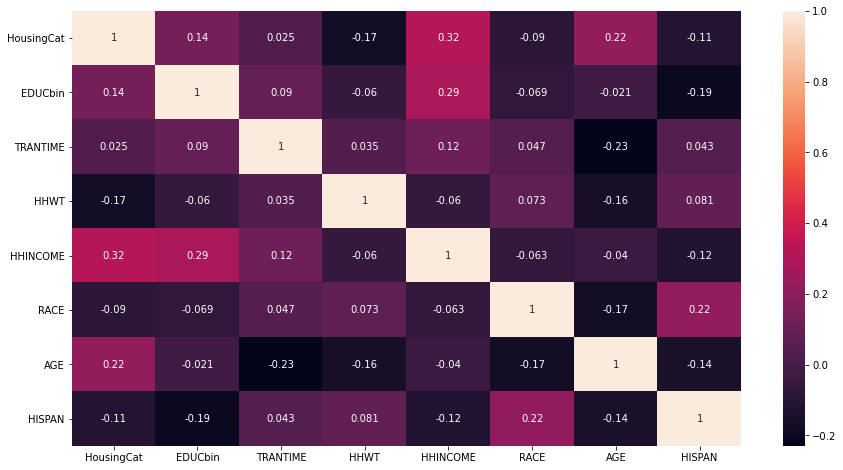

In [24]:
Xcorr10=dfX10fin.iloc[:, [0,1,2,3,4,5,6,7]]
plt.subplots(figsize=(15,8))
sns.heatmap(Xcorr10.corr(), annot = True)


In [25]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
kmeans.fit(dfX00.iloc[:,0:3])
X00fin = scaler.inverse_transform(dfX00)
dfX00fin = pd.DataFrame(X00fin, columns=['HousingCat','EDUCbin','TRANTIME','HHWT','HHINCOME','RACE','AGE','HISPAN'])
dfX00fin['labels'] = kmeans.labels_
cluster_sum00 = dfX00fin.groupby(by = 'labels').mean()
cluster_sum00.head(5)


,HousingCat,EDUCbin,TRANTIME,HHWT,HHINCOME,RACE,AGE,HISPAN
labels,,,,,,,,
0,2.000000,0.000000,5.254506,19.414515,70220.220164,2.605164,51.984926,0.450892
1,1.771384,1.000000,11.474760,20.018845,109942.843099,2.185257,46.861450,0.169286
2,0.496251,0.098901,6.877630,20.356180,46808.401912,3.331018,41.258173,0.687184
3,1.507873,0.323089,146.915367,20.091673,85338.924754,2.818471,41.733611,0.543755
4,1.559551,0.310711,46.694928,20.151610,89114.032935,2.851822,40.370807,0.494625


<AxesSubplot:>

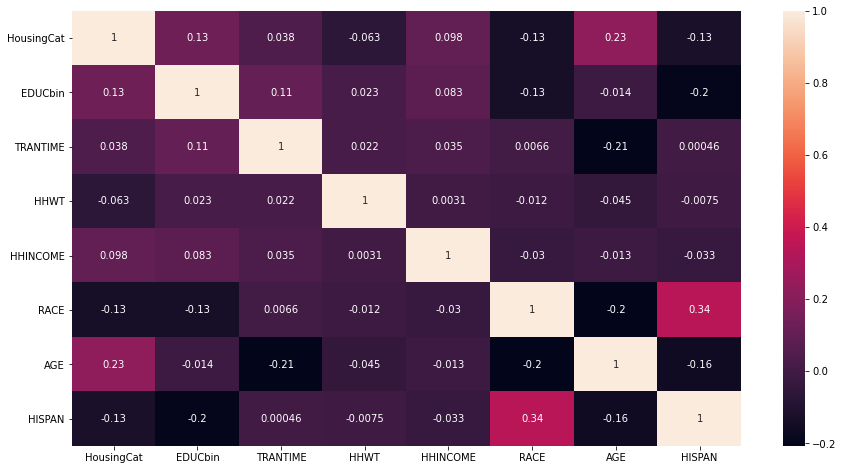

In [26]:
Xcorr00=dfX00fin.iloc[:, [0,1,2,3,4,5,6,7]]
plt.subplots(figsize=(15,8))
sns.heatmap(Xcorr00.corr(), annot = True)


In [27]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
kmeans.fit(dfX90.iloc[:,0:3])
X90fin = scaler.inverse_transform(dfX90)
dfX90fin = pd.DataFrame(X90fin, columns=['HousingCat','EDUCbin','TRANTIME','HHWT','HHINCOME','RACE','AGE','HISPAN'])
dfX90fin['labels'] = kmeans.labels_
cluster_sum90 = dfX90fin.groupby(by = 'labels').mean()
cluster_sum90.head(5)


,HousingCat,EDUCbin,TRANTIME,HHWT,HHINCOME,RACE,AGE,HISPAN
labels,,,,,,,,
0,1.606807,0.462237,58.042470,20.400071,63001.077618,2.124509,39.212192,0.341546
1,1.640521,0.000000,23.308855,20.141234,54674.255810,2.384744,38.971023,0.445180
2,1.770163,1.000000,12.734500,19.961829,70935.422356,1.750533,43.856764,0.145314
3,1.746856,0.000000,2.019100,19.804447,44541.738522,2.068933,50.941637,0.333469
4,0.000000,0.183178,9.379891,22.045561,17151.566308,2.585498,40.231366,0.516268


<AxesSubplot:>

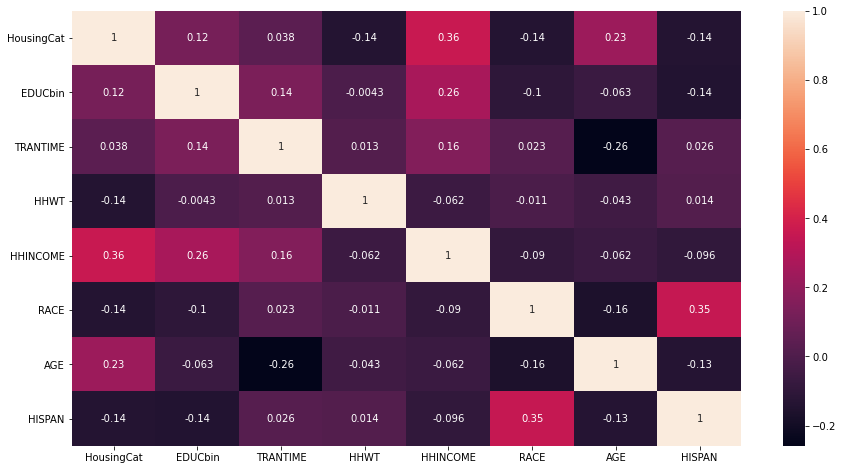

In [28]:
Xcorr90=dfX90fin.iloc[:, [0,1,2,3,4,5,6,7]]
plt.subplots(figsize=(15,8))
sns.heatmap(Xcorr90.corr(), annot = True)


In [29]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
kmeans.fit(dfX80.iloc[:,0:3])
X80fin = scaler.inverse_transform(dfX80)
dfX80fin = pd.DataFrame(X80fin, columns=['HousingCat','EDUCbin','TRANTIME','HHWT','HHINCOME','RACE','AGE','HISPAN'])
dfX80fin['labels'] = kmeans.labels_
cluster_sum80 = dfX80fin.groupby(by = 'labels').mean()
cluster_sum80.head(5)


,HousingCat,EDUCbin,TRANTIME,HHWT,HHINCOME,RACE,AGE,HISPAN
labels,,,,,,,,
0,2.000000,0.000000,2.633039,20.0,25060.807258,1.292833,49.676606,0.237832
1,2.000000,1.000000,3.748936,20.0,34109.453680,1.369774,43.745420,0.122260
2,0.615654,0.000000,3.296933,20.0,15412.601806,1.411451,40.914704,0.406046
3,1.624630,0.437045,43.264693,20.0,29523.650504,1.440235,39.368605,0.276650
4,0.650566,1.000000,4.479624,20.0,19385.336633,1.460412,35.560739,0.176117


<AxesSubplot:>

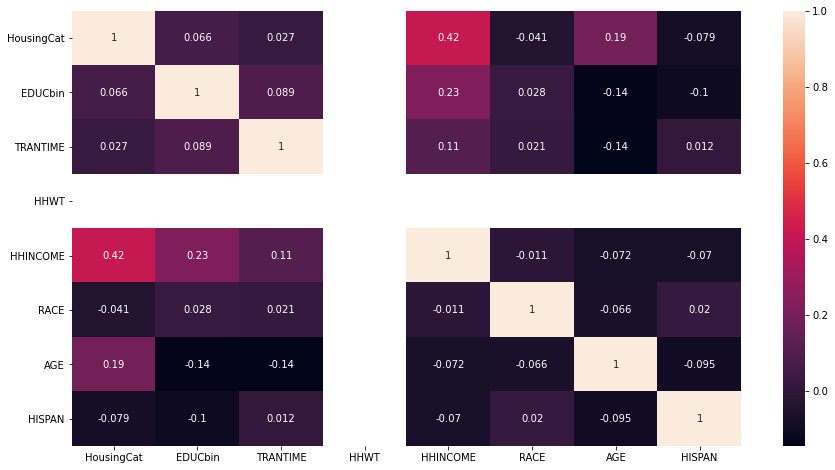

In [30]:
Xcorr80=dfX80fin.iloc[:, [0,1,2,3,4,5,6,7]]
plt.subplots(figsize=(15,8))
sns.heatmap(Xcorr80.corr(), annot = True)
